In [59]:
import pandas as pd
import tqdm
from Bio import SeqIO
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# import keras functions
# import tensorflow
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Input, Flatten, LSTM, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

# performance matrices
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score

# plots
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Reshape, Lambda, Embedding
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
import numpy as np
from Bio import SeqIO
from numpy import array
from numpy import argmax
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.backend import expand_dims
import matplotlib.pyplot as plt
from keras.regularizers import l1, l2
from keras.models import Model
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

In [60]:
def get_input_for_embedding(fasta_file):
    encodings = []
    
    # define universe of possible input values
    alphabet = 'ARNDCQEGHILKMFPSTWYV-'
    
    # define a mapping of chars to integers
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    int_to_char = dict((i, c) for i, c in enumerate(alphabet))
    
    for seq_record in SeqIO.parse(fasta_file, "fasta"):
        data = seq_record.seq
        for char in data:
            if char not in alphabet:
                return
        integer_encoded = [char_to_int[char] for char in data]
        encodings.append(integer_encoded)
    encodings = np.array(encodings)
    return encodings

In [61]:
# convert sequences to integer encoding, for embedding
#test_positive_embedding = get_input_for_embedding('data/Big_testset/fasta/test_positive_sites.fasta')
#test_negative_embedding = get_input_for_embedding('data/Big_testset/fasta/test_negative_sites.fasta')
#train_positive_embedding = get_input_for_embedding('data/DeepSuccinylSite/fasta/positive_sites.fasta')
#train_negative_embedding = get_input_for_embedding('data/DeepSuccinylSite/fasta/negative_sites.fasta')

test_positive_embedding = get_input_for_embedding('../data/test/fasta/test_positive_sites.fasta')
test_negative_embedding = get_input_for_embedding('../data/test/fasta/test_negative_sites.fasta')
train_positive_embedding = get_input_for_embedding('../data/train/fasta/positive_sites.fasta')
train_negative_embedding = get_input_for_embedding('../data/train/fasta/negative_sites.fasta')


# create labels
train_positive_labels = np.ones(train_positive_embedding.shape[0])
train_negative_labels = np.zeros(train_negative_embedding.shape[0])
test_positive_labels = np.ones(test_positive_embedding.shape[0])
test_negative_labels = np.zeros(test_negative_embedding.shape[0])

# stack positive and negative data together
X_train_full_embedding = np.vstack((train_positive_embedding,train_negative_embedding))
X_test_embedding = np.vstack((test_positive_embedding,test_negative_embedding))
y_train_full = np.concatenate((train_positive_labels, train_negative_labels), axis = 0)
y_test = np.concatenate((test_positive_labels, test_negative_labels), axis = 0)

#train_positive_pt5 = pd.read_csv("data/DeepSuccinylSite/features/full/train_positive_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]
#train_negative_pt5 = pd.read_csv("data/DeepSuccinylSite/features/full/train_negative_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]
#test_positive_pt5 = pd.read_csv("data/Big_testset/ProtT5_features/test_positive_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]
#test_negative_pt5 = pd.read_csv("data/Big_testset/ProtT5_features/test_negative_big_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]

train_positive_pt5 = pd.read_csv("../data/train/features/train_positive_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]
train_negative_pt5 = pd.read_csv("../data/train/features/train_negative_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]
test_positive_pt5 = pd.read_csv("../data/test/features/test_positive_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]
test_negative_pt5 = pd.read_csv("../data/test/features/test_negative_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]


# stack positive and negative data together
X_train_pt5_full = np.vstack((train_positive_pt5,train_negative_pt5))
X_test_pt5 = np.vstack((test_positive_pt5,test_negative_pt5))


### Load trained base models

In [62]:
# load models from file
def load_all_models(model_names):
    all_models = list()
    for model in model_names:
        filename = 'selected_models/'+ model + '.h5'
        model = load_model(filename)
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models

# meta learner
def define_stacked_model(members):
    for i in range(len(members)):
        model = members[i]
        for layer in model.layers:
            layer.trainable = False
    ensemble_visible = [model.input for model in members]
    ensemble_outputs = [model.output for model in members]
    merge = concatenate(ensemble_outputs)
    hidden = Dense(16, activation='relu', name = 'ds_1')(merge)
    hidden = Dense(4, activation='relu', name = 'ds_2')(hidden)
    output = Dense(1, activation='sigmoid', name = 'ds_4')(hidden)
    model = Model(inputs = ensemble_visible, outputs = output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# fit a model
def fit_stacked_model(model, inputX, inputy):
    X = [inputX for _ in range(len(model.input))]
    inputy_enc = to_categorical(inputy)
    model.fit(X, inputy_enc, epochs=10, verbose=1)   

# prediction
def predict_stacked_model(model, inputX):
    X = [inputX for _ in range(len(model.input))]
    return model.predict(X, verbose=0)


In [73]:
# load all models
from keras.models import Model
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate

import pandas as pd
import tqdm
from Bio import SeqIO

import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# import keras functions
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Input, Flatten, LSTM, Dropout, Bidirectional
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

# performance matrices
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score

# plots
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Lambda, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
import numpy as np
from Bio import SeqIO
from numpy import array
from numpy import argmax
from sklearn.model_selection import train_test_split
from keras.layers.embeddings import Embedding
from keras import backend as K
from keras.backend import expand_dims
import matplotlib.pyplot as plt
from keras.regularizers import l1, l2
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Layer, GlobalAveragePooling1D, Input, GlobalAveragePooling2D
#from tensorflow.keras.layers import Dense, Embedding
#from tensorflow.keras.models import Sequential


class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=rate)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim)]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        
    def get_config(self):
        config = super().get_config()
        return config

    def call(self, inputs, training):
        attn_output, attention_scores = self.att(inputs, inputs, inputs, return_attention_scores=True, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output), attention_scores


class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim, mask_zero=True)
        
    def get_config(self):
        config = super().get_config()
        return config

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions
    
    
def embedding_model():
    # transformer based embedding model
    vocab_size = 21
    embed_dim = 256 #config["embedding_dim"]
    ff_dim = 128 #config["feed_forward_dim"]
    max_len = 33 #config["maximum_path_length"]
    dropout = 0.2 #config["dropout"]
    n_heads = 8

    inputs = Input(shape=(max_len,))
    embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, n_heads, ff_dim)
    x, weights = transformer_block(x)
    print(x.shape, weights.shape)
    x = GlobalAveragePooling1D()(x) #GlobalAveragePooling1D
    x = Dropout(dropout)(x)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    #x = Dense(int(ff_dim / 2), activation="relu")(x)
    #x = Dropout(dropout)(x)
    x = Dense(16, activation="relu")(x)
    x = Dropout(dropout)(x)
    outputs = Dense(1, activation="sigmoid")(x)
    return Model(inputs=inputs, outputs=[outputs])

Embedding = embedding_model()
Embedding.load_weights("models/transformer_st_model_best.h5")

for i in Embedding.layers:
    print(i)
Prot5 = load_model("models/prot5_st_model_best.h5")

print()
for i in Prot5.layers:
    print(i)

# create truncated models
Embedding_new = Model(inputs=Embedding.input, outputs=Embedding.get_layer(index=8).output)

Prot5_new = Model(inputs=Prot5.input, outputs=Prot5.get_layer(index=6).output)

stacked_model = define_stacked_model([Embedding_new, Prot5_new])

# fit_stacked_model(stacked_model, x_test, y_test)
st_history = stacked_model.fit([X_train_full_embedding, X_train_pt5_full], y_train_full, batch_size=32, epochs=10, verbose=1)

(None, 33, 256) (None, 8, 33, 33)

Model: "model_56"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 33)]         0           []                               
                                                                                                  
 token_and_position_embedding_1  (None, 33, 256)     13824       ['input_14[0][0]']               
 3 (TokenAndPositionEmbedding)                                                                    
                                                                                                  
 transformer_block_13 (Transfor  ((None, 33, 256),   2170496     ['token_and_position_embedding_13
 merBlock)                       (None, 8, 33, 33))              [0][0]']                         
                                                        

In [65]:
# performance evaluation
y_pred_1 = stacked_model.predict([X_test_embedding, X_test_pt5])
y_pred = (y_pred_1 > 0.5)
y_pred = [int(i) for i in y_pred]
y_test = np.array(y_test)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

# plot(history)
print("\n %s, %s, %s, %s, %s \n" %(str(acc), str(mcc), str(sn), str(sp), cm))


 0.7566646001239926, 0.3440716285805378, 0.83399209486166, 0.7500840901446351, [[2230  743]
 [  42  211]] 



In [72]:
stacked_model.summary()

Model: "model_51"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 33)]         0           []                               
                                                                                                  
 token_and_position_embedding_1  (None, 33, 256)     13824       ['input_13[0][0]']               
 2 (TokenAndPositionEmbedding)                                                                    
                                                                                                  
 transformer_block_12 (Transfor  ((None, 33, 256),   2170496     ['token_and_position_embedding_12
 merBlock)                       (None, 8, 33, 33))              [0][0]']                         
                                                                                           

In [67]:
stacked_model.layers[16].get_config()

{'name': 'ds_2',
 'trainable': True,
 'dtype': 'float32',
 'units': 4,
 'activation': 'relu',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'GlorotUniform',
  'config': {'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

In [68]:
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, Input, LeakyReLU
from tensorflow.keras.models import Sequential, load_model, Model
from sklearn.utils import shuffle
from Bio import SeqIO
from keras import backend as K
import seaborn as sns
import matplotlib.pyplot as plt


X_train_pt5 = np.vstack((train_positive_pt5,train_negative_pt5))
X_test_pt5 = np.vstack((test_positive_pt5,test_negative_pt5))
y_train_pt5 = np.concatenate((train_positive_labels, train_negative_labels), axis = 0)
y_test_pt5 = np.concatenate((test_positive_labels, test_negative_labels), axis = 0)

# create truncated model
truncated_combined_model = Model(inputs=stacked_model.input,
                                 outputs=stacked_model.get_layer(index=16).output)

hidden_features = truncated_combined_model.predict([X_train_full_embedding, X_train_pt5_full])

df = pd.DataFrame()
df['Target'] = y_train_pt5

/scratch/users/anup/condaenv/envs/succsite/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


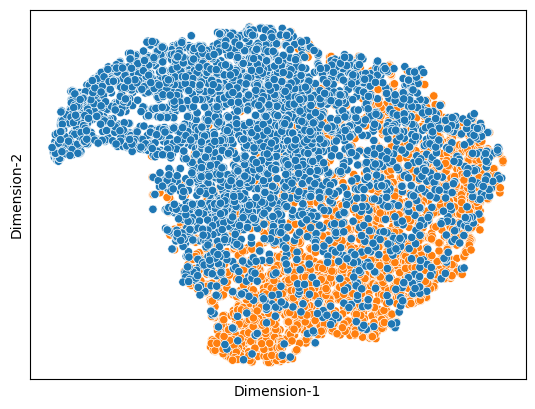

In [69]:
m = TSNE(learning_rate = 20) #learning_rate = 20, perplexity = 30
tsne_features = m.fit_transform(hidden_features)
df['Dimension-1'] = tsne_features[:,0]
df['Dimension-2'] = tsne_features[:,1]

sns.scatterplot(x="Dimension-1",y="Dimension-2",hue='Target',data=df)
plt.tick_params(top=False,
               bottom=False,256
               left=False,
               right=False,
               labelleft=False,
               labelbottom=False)

# plt.axis('off')
# plt.set_xlabel('Subplot 1')
plt.legend().set_visible(False)
filename = "Transformer_TSNE_Combined.png"
plt.savefig(filename,dpi=1600,bbox_inches='tight')
plt.show()

/scratch/users/anup/condaenv/envs/succsite/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


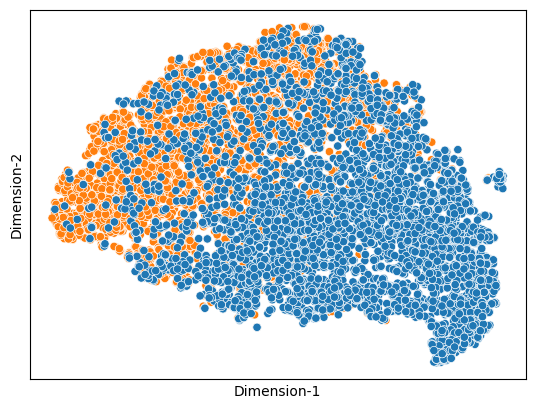

In [70]:
m = TSNE(learning_rate = 30, perplexity=30) #learning_rate = 20, perplexity = 30
tsne_features = m.fit_transform(hidden_features)
df['Dimension-1'] = tsne_features[:,0]
df['Dimension-2'] = tsne_features[:,1]

sns.scatterplot(x="Dimension-1",y="Dimension-2",hue='Target',data=df)
plt.tick_params(top=False,
               bottom=False,
               left=False,
               right=False,256
               labelleft=False,
               labelbottom=False)

# plt.axis('off')
# plt.set_xlabel('Subplot 1')
plt.legend().set_visible(False)
filename = "Transformer_TSNE_Combined.png"
plt.savefig(filename,dpi=1600,bbox_inches='tight')
plt.show()

In [71]:
import tensorflow as tf
gpu = tf.config.list_physical_devices('GPU')
if len(gpu) > 0:
    from numba import cuda
    cuda.select_device(0)
    cuda.close()